In [1]:
# set up paths
from os import pardir, getcwd
from os.path import join, abspath
import sys
nb_dir = getcwd()
project_path = abspath(join(nb_dir, pardir))
sys.path.append(project_path)
# 3rd party imports
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
# ux imports
from ux.interfaces.i_database_manager import IDatabaseManager
from ux.classes.ux.action_template import ActionTemplate
from ux.classes.ux.task import Task
from ux.plots.task_success import plot_task_completion_rates
# local imports
from constants import TOPICS, TOPIC_ABBREVIATIONS
from managers.card_view_manager import CardViewManager
from paths.files import FN_INTERIM_CARD_VIEW
from pmi_examples.helpers import create_card_view_task

## Task Completion

### Single Task Completion

The first step is to create a new instance of the Database Manager that we have written to generate our UX objects from the underlying data logs. In this case our data logs have been processed and transformed into a pandas DataFrame but in theory we can use any database or file system as the data store.

In [2]:
db = CardViewManager(data=FN_INTERIM_CARD_VIEW)

The first step is to define a Task that we will use to measure completion of. Let's take a look at the list of locations that User Actions have been taken at in the database.

In [3]:
db.locations()

[Location(/topic/risk-management/0/0),
 Location(/topic/risk-management/1/2),
 Location(/topic/risk-management/2/29),
 Location(/topic/scheduling/0/0),
 Location(/topic/work-breakdown-structure/0/0),
 Location(/topic/work-breakdown-structure/1/2),
 Location(/topic/personal-kanban/0/0),
 Location(/topic/personal-kanban/0/1),
 Location(/topic/personal-kanban/1/2),
 Location(/topic/personal-kanban/1/3),
 Location(/topic/blend-agile-and-waterfall/0/0),
 Location(/topic/blend-agile-and-waterfall/0/1),
 Location(/topic/blend-agile-and-waterfall/1/2),
 Location(/topic/blend-agile-and-waterfall/1/3),
 Location(/topic/blend-agile-and-waterfall/0/2),
 Location(/topic/risk-management/0/1),
 Location(/topic/risk-management/1/3),
 Location(/topic/risk-management/1/4),
 Location(/topic/risk-management/1/5),
 Location(/topic/risk-management/1/6),
 Location(/topic/risk-management/1/7),
 Location(/topic/risk-management/1/8),
 Location(/topic/risk-management/1/9),
 Location(/topic/risk-management/1/10),

We can see locations corresponding to a number of relative URLs in the following format:
    **/topic/{topic-name}/{lesson-number}/{card-number}**

Let's define a function to create a new Task for a chosen topic.

In [4]:
def create_card_view_task(db: IDatabaseManager, search_text: str, task_name: str):
    """
    :rtype: Task
    """
    # get locations
    locations = db.locations()
    topic_locations = [loc for loc in locations if search_text in loc.location_id]
    topic_locations.sort(key=lambda loc: int(loc.location_id.split('/')[-1]))
    topic_locations.sort(key=lambda loc: int(loc.location_id.split('/')[-2]))
    # define task
    task = Task(task_name)
    for location in topic_locations:
        task.add_action_template(ActionTemplate(
            action_type='card-view',
            source_id=location.location_id
        ))

    return task

And now let's use it to create a new Task that represents a User navigating forwards through each of the Critical PM Relationships cards.

In [5]:
task = create_card_view_task(
    db=db, search_text='critical-pm-relationships',
    task_name='Critical PM Relationships'
)

And now confirm that it worked as expected by accessing the first 10 ActionTemplates contained in the Task.

In [6]:
task.action_templates[:10]

[ActionTemplate(card-view: /topic/critical-pm-relationships/0/0),
 ActionTemplate(card-view: /topic/critical-pm-relationships/0/1),
 ActionTemplate(card-view: /topic/critical-pm-relationships/0/2),
 ActionTemplate(card-view: /topic/critical-pm-relationships/1/2),
 ActionTemplate(card-view: /topic/critical-pm-relationships/1/4),
 ActionTemplate(card-view: /topic/critical-pm-relationships/1/5),
 ActionTemplate(card-view: /topic/critical-pm-relationships/1/6),
 ActionTemplate(card-view: /topic/critical-pm-relationships/1/7),
 ActionTemplate(card-view: /topic/critical-pm-relationships/1/8),
 ActionTemplate(card-view: /topic/critical-pm-relationships/1/9)]

We can also get a summary of the Task Name and the number of Templates it contains

In [7]:
task

Task(Critical PM Relationships [49])

Now we want to iterate through each of the Sessions in the database and find those that contain UserActions that look like the Templates we defined as part of the Task. First we need to retrieve the Sessions.

In [8]:
sessions = db.sessions()

Now let's iterate through them and measure the rates of ordered and unordered task completion for each

In [9]:
# create some lists to store unordered and ordered task completion rates
unordered_completion_rates = []
ordered_completion_rates = []
# scan through the user sessions
for session in tqdm(sessions, 'Scanning Sessions'):  # tqdm gives us a cool progress bar for long tasks
    session_sequence = db.get_session_sequence(session.session_id)  # create an ActionSequence from the Session
    if not session_sequence.intersects_task(task):
        continue
    unordered_completion_rate = task.unordered_completion_rate(session_sequence)
    unordered_completion_rates.append(unordered_completion_rate)
    ordered_completion_rate = task.ordered_completion_rate(session_sequence)
    ordered_completion_rates.append(ordered_completion_rate)

Scanning Sessions: 100%|██████████| 1191/1191 [00:10<00:00, 118.61it/s]


Now that we have populated the lists we want to visualize them. First let's put them into a dictionary structure.

In [10]:
completion_rates = dict(
    ordered=ordered_completion_rates,
    unordered=unordered_completion_rates
)

Finally we can call a plot method from the UX library to plot a comparison

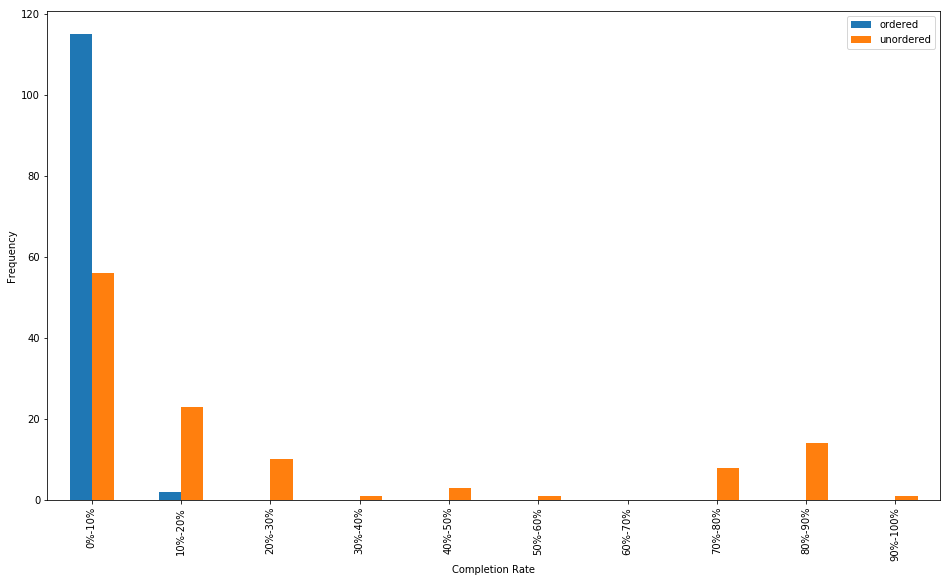

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_task_completion_rates(completion_rates, ax=ax)

### Multiple Task Completion

Ok so we can do something for one Task. What about measuring completion for all of the topics? This is pretty simple - we just need to create moree Tasks and check for completion against each of them as we iterate through the session logs.

First step is to define the Tasks:

In [12]:
def create_all_card_view_tasks(db: IDatabaseManager):
    """
    :rtype: List[Task]
    """
    tasks = [create_card_view_task(
        db=db, search_text=topic['slug_text'],
        task_name=topic['topic']
    ) for _, topic in TOPICS.iterrows()]

    return tasks

tasks = create_all_card_view_tasks(db)

Let's double-check that it worked

In [13]:
tasks

[Task(Blend Agile and Waterfall [6]),
 Task(Critical PM Relationships [49]),
 Task(Gathering Requirements [50]),
 Task(Personal Kanban [6]),
 Task(Retrospectives [6]),
 Task(Risk Management [52]),
 Task(Scheduling [73]),
 Task(Work Breakdown Structure [6])]

In [14]:
tasks[1].action_templates[2]

ActionTemplate(card-view: /topic/critical-pm-relationships/0/2)

Looks okay. Now for the iteration. Start by creating different data structures to hold the ordered and unordered results in:

In [15]:
unordered_completion_rates = defaultdict(list)
ordered_completion_rates = defaultdict(list)

Now the modified iteration loop:

In [16]:
for session in tqdm(sessions, 'Scanning Sessions'):
    session_sequence = db.get_session_sequence(session.session_id)
    for task in tasks:
        if not session_sequence.intersects_task(task):
            continue
        unordered_completion_rate = task.unordered_completion_rate(session_sequence)
        unordered_completion_rates[task.name].append(unordered_completion_rate)
        ordered_completion_rate = task.ordered_completion_rate(session_sequence)
        ordered_completion_rates[task.name].append(ordered_completion_rate)

Scanning Sessions: 100%|██████████| 1191/1191 [00:10<00:00, 108.68it/s]


And finally the plot of completion for each topic in one plot.

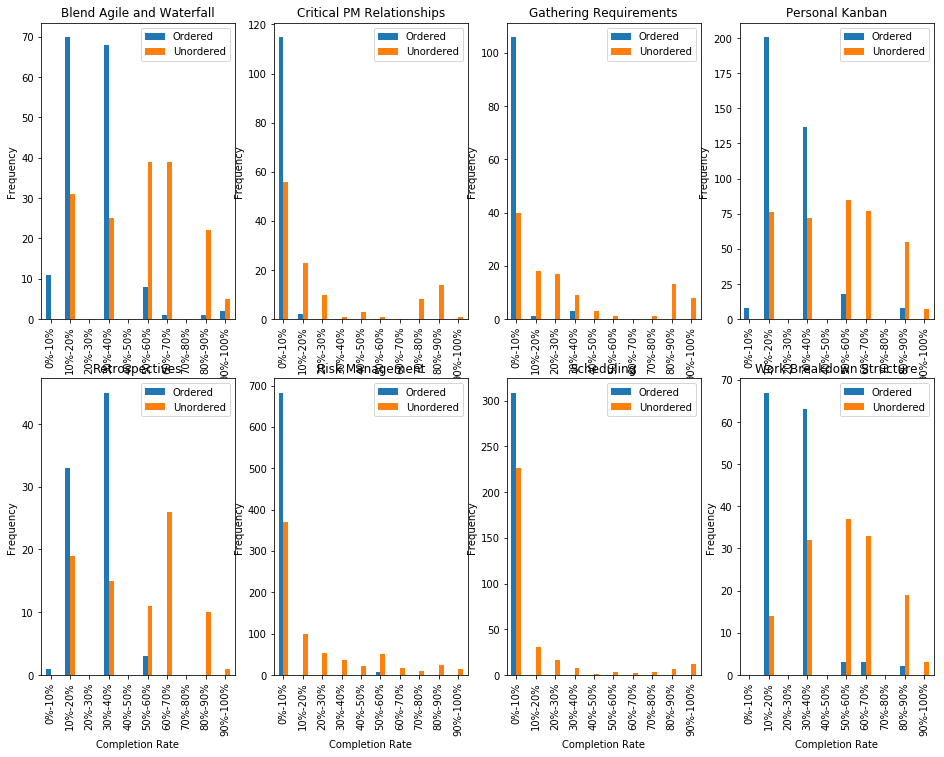

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 12))
for t, topic in enumerate(TOPICS['topic'].to_list()):
    ax = axes.flat[t]
    ax.set_title(topic)
    topic_rates = {
        'Ordered': ordered_completion_rates[topic],
        'Unordered': unordered_completion_rates[topic]
    }
    plot_task_completion_rates(completion_rates=topic_rates, ax=ax)